In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import sys
sys.path.append("../scripts/")
from clean_data import DataCleaner
from utils import Utils
from HypothesisPlot import HypothesisPlot 
from DistributionPlots import DistributionPlots 

import warnings
warnings.filterwarnings('ignore')

In [2]:
cleaner = DataCleaner()
util=Utils()
dp=DistributionPlots()
hp=HypothesisPlot()


In [3]:
df = util.load_data('../data/AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


### Classical A/B Testing

In [6]:
responsive_users= cleaner.drop_unresponsive(df)
responsive_users.groupby('experiment').agg({'auction_id':'count','yes':'sum','no':'sum'})


,auction_id,yes,no
experiment,,,
control,586,264,322
exposed,657,308,349


In [7]:
responsive_users 

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1
...,...,...,...,...,...,...,...,...,...
8059,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1,0
8063,ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,2020-07-04,1,Generic Smartphone,6,Chrome Mobile,1,0
8064,ffb79718-6f25-4896-b6b3-e58b80a6e147,control,2020-07-09,7,Generic Smartphone,6,Chrome Mobile,0,1
8069,ffca1153-c182-4f32-9e90-2a6008417497,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0,1


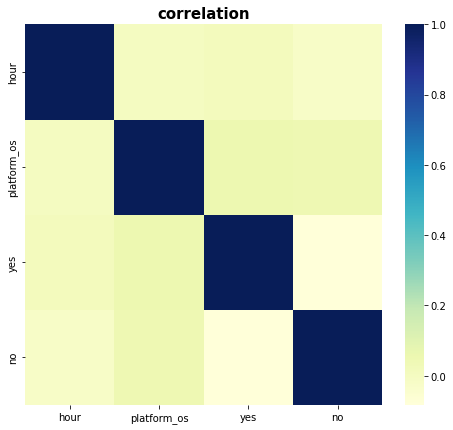

In [4]:
# Correlation Analysis

plt.figure(figsize=(8, 7))
corr = df.corr()
sns.heatmap(corr,cmap="YlGnBu")
plt.title('correlation', fontsize=15, fontweight='bold')
plt.show()

In [8]:
ab_summary = responsive_users.pivot_table(values='yes', index='experiment', aggfunc=np.sum)
ab_summary['total'] = responsive_users.pivot_table(values='yes', index='experiment', aggfunc=lambda x: len(x))
ab_summary['no']=ab_summary['total']-ab_summary['yes']
ab_summary['baseline rate'] = responsive_users.pivot_table(values='yes', index='experiment') # sums all the yes values(counts yes values) and divide to the total so it gives us the yes percentage
ab_summary=ab_summary[['yes','no','total','baseline rate']]
ab_summary

,yes,no,total,baseline rate
experiment,,,,
control,264,322,586,0.450512
exposed,308,349,657,0.468798


In [9]:
cr_exposed=ab_summary.loc['exposed','baseline rate']
cr_control=ab_summary.loc['control','baseline rate']
print(f"the conversion rate between control and exposed group is {cr_exposed-cr_control}")

the conversion rate between control and exposed group is 0.018285619295484168


### visualization of aware groups

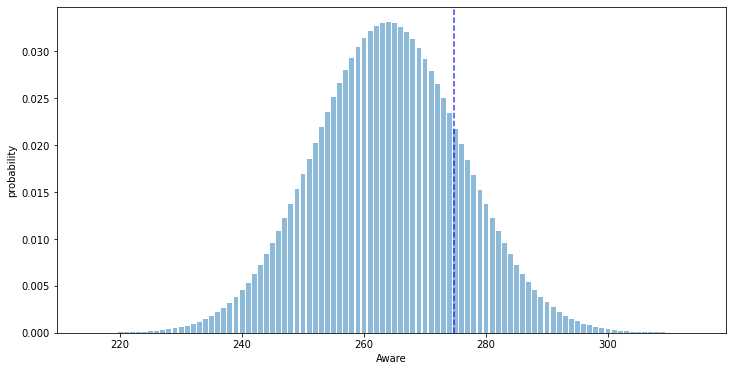

In [10]:
c_aware=ab_summary['yes']['control']
c_total=ab_summary['total']['control']
e_aware=ab_summary['yes']['exposed']
e_total=ab_summary['total']['exposed']
c_cr,e_cr= ab_summary['baseline rate']
dp.cont_distribution(c_aware,c_total,c_cr,e_cr)

### visualization of the two groups

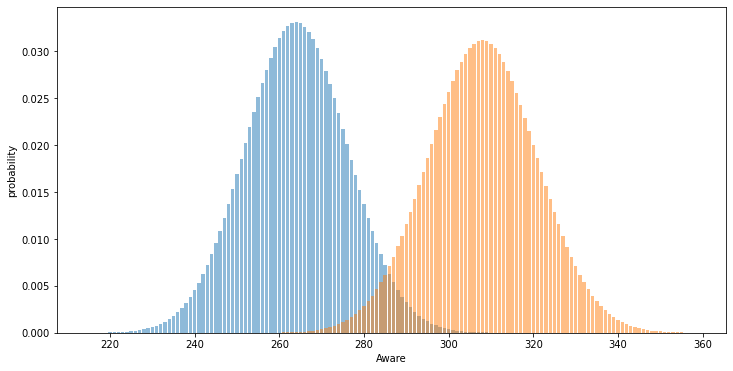

In [11]:
dp.cont_exp_distribution(c_aware,e_aware,c_total,e_total,c_cr,e_cr)

we can see that the controlled group converted more than the exposed group

### Standard Error of Mean

> `SE (control) = √((control baseline rate * (1 - control baseline rate)) / total control )` <br>
> `SE (exposed)= √((exposed baseline rate * (1 - exposed baseline rate)) / total exposed )`

In [12]:
se_control = np.sqrt((c_cr * (1 - c_cr)) / c_total)
se_exposed = np.sqrt((e_cr * (1 - e_cr)) / e_total)

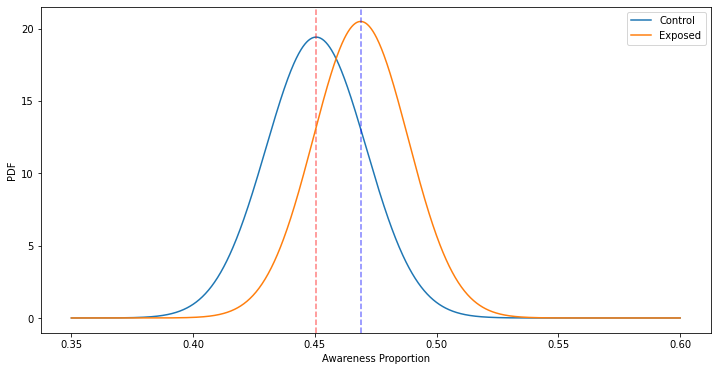

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(c_cr, se_control).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=c_cr, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(e_cr, se_exposed).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=e_cr, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')
plt.show()

we can see the mean conversion rates from each group represented by the vertical broken lines